# Clustering

We will introduce our first unsupervised learning task: clustering. Clustering is used to find groups of similar observations within a set of unlabeled data. We will discuss the K-means clustering algorithm. Finally, we will work through a semi-supervised learning problem that combines clustering with classification.

The goal of unsupervised learning is to discover hidden structures or patterns in unlabeled training data. Clustering, or cluster analysis, is the task of grouping observations so that members of the same group, or cluster, are more similar to each other by some metric than they are to members of other clusters. As with supervised learning, we will represent an observation as an n-dimensional vector.

![Fig](imgs/img_001.png)

Clustering is commonly used to explore a dataset. Social networks can be clustered to identify communities and to suggest missing connections between people. In biology, clustering is used to find groups of genes with similar expression patterns. Recommendation systems sometimes employ clustering to identify products or media that might appeal to a user. In marketing, clustering is used to find segments of similar consumers. In the following sections, we will work through an example of using the K-means algorithm to cluster a dataset.

## K-Means

The K-means algorithm is a clustering method that is popular because of its speed and scalability. K-means is an iterative process of moving the centers of the clusters, called the centroids, to the mean position of their constituent instances and re-assigning instances to the clusters with the closest centroids. The titular k is a hyperparameter that specifies the number of clusters that should be created; K-means automatically assigns observations to clusters but cannot determine the appropriate number of clusters. k must be a positive integer that is less than the number of instances in the training set. Sometimes the number of clusters is specified by the clustering problem's context. 

For example, a company that manufactures shoes might know that it is able to support manufacturing three new models. To understand what groups of customers to target with each model, it surveys customers and creates three clusters from the results, that is, the number of clusters specified by the problem's context. Other problems may not require a specific number of clusters, and the optimal number of clusters may be ambiguous. We will discuss a heuristic for estimating the optimal number of clusters called the elbow method

![Fig](imgs/img_002.png)

Here, μk is the centroid for cluster k. The cost function sums the distortions of the clusters. Each cluster's distortion is equal to the sum of the squared distances between its centroid and its constituent instances. The distortion is small for compact clusters and large for clusters that contain scattered instances. The parameters that minimize the cost function are learned through an iterative process of assigning observations to clusters and then moving the clusters. First, the clusters' centroids are initialized, often by randomly selecting instances. During each iteration, K-means assigns observations to the cluster that they are closest to and then moves the centroids to their assigned observations' mean location.

### Elbow method

If k is not specified by the problem's context, the optimal number of clusters can be estimated using a technique called the elbow method. The elbow method plots the value of the cost function produced by different values of k. As k increases, the average distortion will decrease; each cluster will have fewer constituent instances, and the instances will be closer to their respective centroids. However, the improvements to the average dispersion will decline as k increases. The value of k at which the improvement to the dispersion declines the most is called the elbow.

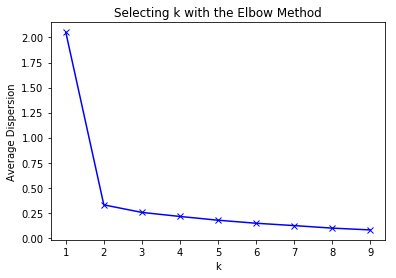

In [3]:
import numpy as np 
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
%matplotlib inline

c1x = np.random.uniform(0.5, 1.5, (1, 10)) 
c1y = np.random.uniform(0.5, 1.5, (1, 10)) 
c2x = np.random.uniform(3.5, 4.5, (1, 10)) 
c2y = np.random.uniform(3.5, 4.5, (1, 10)) 
x = np.hstack((c1x, c2x)) 
y = np.hstack((c1y, c2y)) 
X = np.vstack((x, y)).T

K = range(1, 10) 
meanDispersions = [] 
for k in K: 
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(X) 
    meanDispersions.append(sum(np.min(cdist(X,kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(K, meanDispersions, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Average Dispersion') 
plt.title('Selecting k with the Elbow Method') 
plt.show()

### Image Quantization

In previous sections, we used clustering to explore the structure of a dataset. Now let's apply it to a different problem. Image quantization is a lossy compression method that replaces a range of similar colors in an image with a single color. Quantization reduces the size of the image file since fewer bits are required to represent the colors. In the following example, we will use clustering to discover a compressed palette for an image that contains its most important colors. We will then rebuild the image using the compressed palette. First we read and flatten the image:

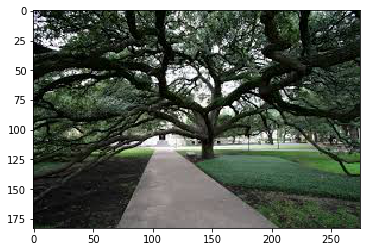

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from PIL import Image

original_img = np.array(Image.open('../datasets/tree.jpg'))
plt.imshow(original_img)

In [14]:
original_img.shape

(183, 275, 3)

In [15]:
183 * 275

50325

In [7]:
original_img = np.array(Image.open('../datasets/tree.jpg'), dtype=np.float64) /255
original_dimensions = tuple(original_img.shape)
width, height, depth = tuple(original_img.shape)
image_flattened = np.reshape(original_img, (width * height, depth))

In [8]:
# We then use K-means to create 64 clusters from a sample of 1000 randomly selected colors. 
# Each of the clusters will be a color in the compressed palette:

image_array_sample = shuffle(image_flattened, random_state=0)[:1000]
estimator = KMeans(n_clusters=64, random_state=0)
estimator.fit(image_array_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=64, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [9]:
# Next, we predict the cluster assignment for each of the pixels in the original image:
cluster_assignments = estimator.predict(image_flattened)

In [13]:
cluster_assignments.shape

(50325,)

In [17]:
# Finally, we create the compressed image from the compressed palette and cluster assignments:

compressed_palette = estimator.cluster_centers_

In [16]:
compressed_palette.shape

(64, 3)

In [18]:
compressed_img = np.zeros((width, height, compressed_palette.shape[1]))
label_idx = 0
for i in range(width):
    for j in range(height):
        compressed_img[i][j] =compressed_palette[cluster_assignments[label_idx]]
        label_idx += 1

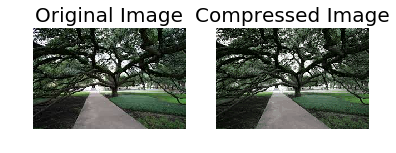

In [20]:
plt.subplot(121)
plt.title('Original Image', fontsize=20)
plt.imshow(original_img)
plt.axis('off')
plt.subplot(122)
plt.title('Compressed Image', fontsize=20)
plt.imshow(compressed_img)
plt.axis('off')
plt.show()

## Semisupervised learning: Clustering with labels

In this example, we will combine clustering with classification in a semi-supervised learning problem. We will learn features by clustering unlabeled data, and use the learned features to build a supervised classifier.
Suppose that you own a cat and a dog. Further suppose that you have purchased a smartphone, ostensibly to use to communicate with humans, but in practice just to use to photograph your cat and dog. Your photographs are awesome, and you are certain that your friends and co-workers would love to review all of them in detail. You'd like to be courteous and respect that some people will only want to see your cat photos while others will only want to see your dog photos, but separating the photos is laborious. Let's build a semi-supervised learning system that can classify images of cats and dogs.

A naive approach to classifying images is to use the intensities, or brightnesses, of all the pixels as features. This approach produces high-dimensional feature vectors for even small images. Unlike the high-dimensional feature vectors we used to represent documents, these vectors are not sparse. Furthermore, it is obvious that this approach is sensitive to the image's illumination, scale, and orientation. We will extract SURF descriptors from the images and cluster them to learn a feature representation. SURF descriptors describe interesting regions of an image and are somewhat invariant to scale, rotation, and illumination. We will then represent an image with a vector with one element for each cluster of descriptors. 

Each element will encode the number of descriptors extracted from the image that were assigned to the cluster. This approach is sometimes called the bag-of-features representation, as the collection of clusters is analogous to the bag-of-words representation's vocabulary.

## Dimensionality reduction with  Principal Component Analysis

The curse of dimensionality refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces (often with hundreds or thousands of dimensions) that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience. 

Dimensionality reduction is motivated by several problems. Firstly, it can be used to mitigate problems caused by the curse of dimensionality. Secondly, dimensionality reduction can be used to compress data while minimizing the amount of information that is lost. Thirdly, understanding the structure of data with hundreds of dimensions can be difficult; data with only two or three dimensions can be visualized easily. We will use PCA to visualize a high-dimensional dataset in two dimensions and to build a face recognition system.

PCA also known as the Karhunen-Loeve Transform (KLT), is a technique for finding patterns in high-dimensional data. PCA is commonly used to explore and visualize high-dimensional datasets. It can also be used to compress data and to process data before it is used by another estimator. PCA reduces a set of possibly correlated high-dimensional variables to a lower dimensional set of linearly uncorrelated synthetic variables called principal components. The lower dimensional data preserves as much of the variance of the original data as possible. PCA reduces the dimensions of a dataset by projecting the data onto a lower dimensional subspace. For example, a two-dimensional dataset could be reduced by projecting the points onto a line; each instance in the dataset would then be represented by a single value rather than by a pair of values. A three-dimensional dataset could be reduced to two dimensions by projecting the variables onto a plane. In general, an m-dimensional dataset can be reduced by projecting onto an n-dimensional subspace, where n is less than m. More formally, PCA can be used to find a set of vectors that span a subspace that minimizes the sum of the squared errors of the projected data. This projection will retain the greatest proportion of the original dataset's variance.

### Performing PCA

Let's use PCA to reduce 2-D dataset to 1-D

![Fig](imgs/img_003.png)

![Fig](imgs/img_004.png)

In [30]:
x1 = [0.9, 2.4, 1.2, 0.5, 0.3, 1.8, 0.5, 0.3, 2.5, 1.3]
x2 = [1, 2.6, 1.7, 0.7, 0.7, 1.4, 0.6, 0.6, 2.6, 1.1]

np.cov(x1, x2)

array([[0.68677778, 0.60666667],
       [0.60666667, 0.59777778]])

In [25]:
cov = np.cov(x1, x2)

In [26]:
w, v = np.linalg.eig(cov)

In [27]:
w,v

(array([1.25057433, 0.03398123]), array([[ 0.73251454, -0.68075138],
        [ 0.68075138,  0.73251454]]))

Next we will project the data onto the principal components. The first eigenvector has the greatest eigenvalue and is the first principal component. We will build a transformation matrix in which each column of the matrix is the eigenvector for a principal component. If we were reducing a five-dimensional dataset to three dimensions, we would build a matrix with three columns. In this example, we will project our two-dimensional dataset onto one dimension, so we will use only the eigenvector for the first principal component. Finally, we will find the dot product of the data matrix and the transformation matrix. The following is the result of projecting our data onto the first principal component:

In [31]:
x1_p = x1 - np.mean(x1)
x2_p = x2 - np.mean(x2)

In [71]:
z = list(zip(x1_p, x2_p))

In [72]:
A = np.array(z)

In [73]:
A

array([[-0.27, -0.3 ],
       [ 1.23,  1.3 ],
       [ 0.03,  0.4 ],
       [-0.67, -0.6 ],
       [-0.87, -0.6 ],
       [ 0.63,  0.1 ],
       [-0.67, -0.7 ],
       [-0.87, -0.7 ],
       [ 1.33,  1.3 ],
       [ 0.13, -0.2 ]])

In [74]:
v[1]

array([0.68075138, 0.73251454])

In [75]:
A.reshape(-1,2)

array([[-0.27, -0.3 ],
       [ 1.23,  1.3 ],
       [ 0.03,  0.4 ],
       [-0.67, -0.6 ],
       [-0.87, -0.6 ],
       [ 0.63,  0.1 ],
       [-0.67, -0.7 ],
       [-0.87, -0.7 ],
       [ 1.33,  1.3 ],
       [ 0.13, -0.2 ]])

In [76]:
np.matmul(A.reshape(-1,2), v[1].reshape(-1,1))

array([[-0.40355724],
       [ 1.78959311],
       [ 0.31342836],
       [-0.89561215],
       [-1.03176243],
       [ 0.50212483],
       [-0.96886361],
       [-1.10501388],
       [ 1.85766824],
       [-0.05800523]])

In [50]:
(-0.27*0.732) + (-0.3 * 0.681) 

-0.40194

### Example of PCA

It is easy to discover patterns by visualizing data with two or three dimensions. A high-dimensional dataset cannot be represented graphically, but we can still gain some insights into its structure by reducing it to two or three principal components. Collected in 1936, Fisher's Iris dataset is a collection of fifty samples from each of three species of Iris: Iris setosa, Iris virginica, and Iris versicolor. The explanatory variables are measurements of the length and width of the petals and sepals of the flowers. The Iris dataset is commonly used to test classification models, and is included with scikit-learn. Let's reduce the iris dataset's four dimensions so that we can visualize it in two dimensions.

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
%matplotlib inline


In [79]:

data = load_iris()
y = data.target
X = data.data
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)

red_x, red_y = [], []
blue_x, blue_y = [], []
green_x, green_y = [], []
for i in range(len(reduced_X)):
    if y[i] == 0:
        red_x.append(reduced_X[i][0])
        red_y.append(reduced_X[i][1])
    elif y[i] == 1:
        blue_x.append(reduced_X[i][0])
        blue_y.append(reduced_X[i][1])
    else:
        green_x.append(reduced_X[i][0])
        green_y.append(reduced_X[i][1])

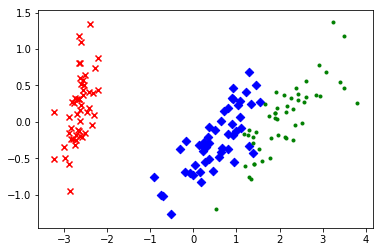

In [80]:

plt.scatter(red_x, red_y, c='r', marker='x')
plt.scatter(blue_x, blue_y, c='b', marker='D')
plt.scatter(green_x, green_y, c='g', marker='.')
plt.show()